In [ ]:
from IPython.display import Image, display
from IPython.display import HTML
from IPython.display import display, Markdown

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import pandas as pd
import prettytable

In [ ]:
## Mount Drive into Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Deep active learning with diversity sampling**

In this experiment, we try to see if and how diversity sampling strategy reduces the calibration error of machine learning models. We further compare the performance of diversity sampling to uncertainty sampling and random sampling.

As a first step, we trained the fine-tuned base cased DistilBERT model with the cross-entropy loss using hard targets. We used Adam optimizer, and DistilBertTokenizer from transformers. 

We used the same datasets and the related hyperparameters we selected in our previous experiments on soft targets. All configurations are presented in the table below.


In [ ]:
x = PrettyTable()
column_names = ["Dataset", "Train/val/test", "Classes", "Class weights", "Learning rate", "Number of active learning batches", "Batch Size", "Size of initial training data", "Max epochs"]
x.add_column(column_names[0], ['Economic news article tone and relevance','Chems Contributing to Disease','Corporate messaging', 'Sentiment Self-driving Cars', 'Drug relation'])
x.add_column(column_names[1], ["5098/452/526","3088/186/162","2615/120/117", "5399/150/147", "1866/75/72"])
x.add_column(column_names[2], [2, 2, 3, 3, 3])
x.add_column(column_names[3], ["[1, 4]", "[1, 4]", "[1, 1, 1]", "[1, 1, 1]", "[1, 1, 1]"])
x.add_column(column_names[4], ["[1e-06]", "[1e-06]", "[1e-06]", "[1e-06]", "[1e-06]"])
x.add_column(column_names[5], ["10","10","10","10","10"])
x.add_column(column_names[6], ["500", "300", "255", "530", "180"])
x.add_column(column_names[7], ["98", "88", "66", "99", "66"])
x.add_column(column_names[8], ["40", "40", "85", "55", "80"])
print(x)

+------------------------------------------+----------------+---------+---------------+---------------+-----------------------------------+------------+-------------------------------+------------+
|                 Dataset                  | Train/val/test | Classes | Class weights | Learning rate | Number of active learning batches | Batch Size | Size of initial training data | Max epochs |
+------------------------------------------+----------------+---------+---------------+---------------+-----------------------------------+------------+-------------------------------+------------+
| Economic news article tone and relevance |  5098/452/526  |    2    |     [1, 4]    |    [1e-06]    |                 10                |    500     |               98              |     40     |
|      Chems Contributing to Disease       |  3088/186/162  |    2    |     [1, 4]    |    [1e-06]    |                 10                |    300     |               88              |     40     |
|         

In [ ]:
def printSelectedItems(eval_outliers, data):
    print("Sampled items in the first batch:")
    sampled_items = []
    outliers = str(eval_outliers).split()
    for outlier in outliers:
        outlier_id = int(outlier)
        outlier_text = data.loc[data['itemID'] == outlier_id].text.values
        if len(outlier_text) != 0 and outlier_text[0] not in sampled_items:
            sampled_items.append(outlier_text[0])

    for item in sampled_items:
        print("\n", item)

def printPrettyTable(title, column_names, datasetName, eval, test):
    x = PrettyTable()
    x.title = title
    x.add_column(column_names[0], [datasetName, '', '', '', '', '', '', '', '', ''])
    x.add_column(column_names[1], test['alBatch'] )
    x.add_column(column_names[2], eval[' f1_val'])
    x.add_column(column_names[3], eval[' ece_val'])
    x.add_column(column_names[4], test[' f1_val'])
    x.add_column(column_names[5], test[' ece_val'])
    print(x)

def plot_performance(X, YSet, xLabel, yLabel, labels, title, legendLoc):
    y_f1 = []
    y_ece = []
    for el in YSet:
      y_f1.append(el[0])
      y_ece.append(el[1])

    fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
    fig.suptitle(title)

    for y_arr, label in zip(y_f1, labels):
        ax[0].plot(X, y_arr, label=label)

    for y_arr, label in zip(y_ece, labels):
        ax[1].plot(X, y_arr, label=label)
    
    ax[0].set_title('F1 Scores')
    ax[0].set_xlabel(xLabel)
    ax[0].set_ylabel(yLabel)
    ax[0].legend(loc=legendLoc, prop={'size': 8})
    ax[0].set_ylim([0, 1])
    ax[1].set_title('ECE Scores')
    ax[1].set_xlabel(xLabel)
    ax[1].set_ylabel(yLabel)
    ax[1].legend(loc='upper left', prop={'size': 8})
    ax[1].set_ylim([0, 1])
    plt.show()

# ***Economic News Dataset***
Contributors read snippets of news articles. They then noted if the article was relevant to the US economy and, if so, what the tone of the article was. Tone was judged on a 9 point scale (from 1 to 9, with 1 representing the most negativity). Dataset contains these judgments as well as the dates, source titles, and text. Dates range from 1951 to 2014. 

Source: https://www.crowdflower.com/data-for-everyone/


In [ ]:
#read data and results

res_path = 'drive/My Drive/Colab Notebooks/deepALForCalibration/res/'
data_folder = 'drive/My Drive/Colab Notebooks/deepALForCalibration/datasets/binary/economic_news/'

unlabeled_data_dir = data_folder + '4_train_indexed_economic_news_binary.csv'
diversity_res_eval_dir = res_path + 'diversity_4-economic_news-lr10-6-1&4cw_maxEpoch40_last.csv'
diversity_res_test_dir = res_path + 'diversity_test_4-economic_news-lr10-6-1&4cw_alB10_ep6_it0.csv'
uncertainty_res_eval_dir = res_path + 'uncertainty_4-economic_news-lr10-6-1&4cw_maxEpoch40.csv'
uncertainty_res_test_dir = res_path + 'uncertainty_test_4-economic_news-lr10-6-1&4cw_alB10_ep9_it0.csv'
random_res_eval_dir = res_path + 'random_4-economic_news-lr10-6-1&4cw_maxEpoch40_last.csv'
random_res_test_dir = res_path + 'random_test_4-economic_news-lr10-6-1&4cw_alB10_ep15_it0.csv'

data = pd.read_csv(unlabeled_data_dir)
diversity_res_eval = pd.read_csv(diversity_res_eval_dir)
diversity_res_test = pd.read_csv(diversity_res_test_dir)
uncertainty_res_eval = pd.read_csv(uncertainty_res_eval_dir)
uncertainty_res_test = pd.read_csv(uncertainty_res_test_dir)
random_res_eval = pd.read_csv(random_res_eval_dir)
random_res_test = pd.read_csv(random_res_test_dir)

**Performance of DistilBERT model when using active learning for calibration**

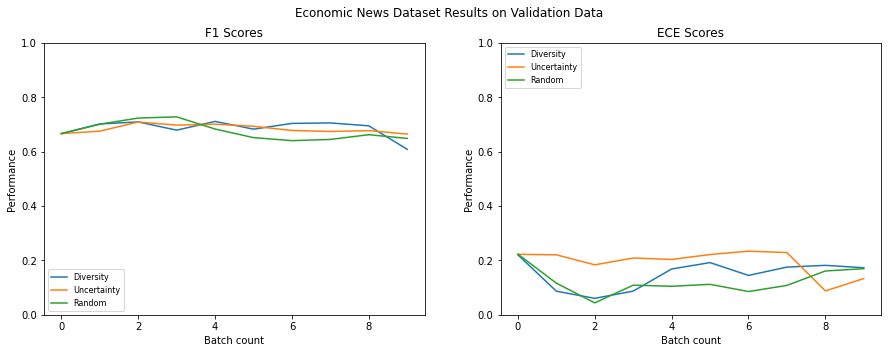

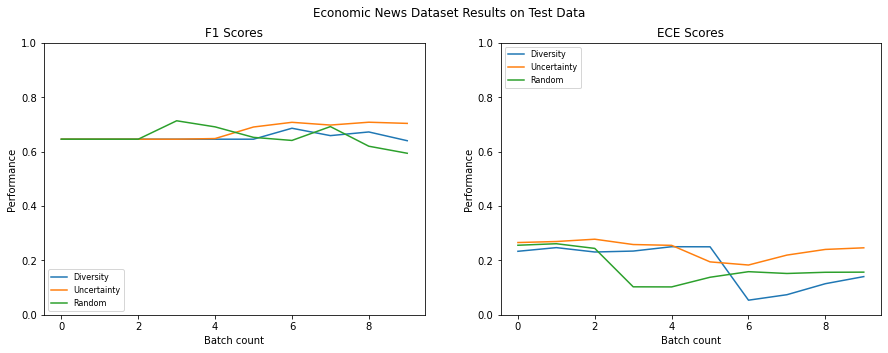

+----------------------------------------------------------------------------------------------------------------------------------------------+
|                             Diversity sampling results for the Economic news article tone and relevance Dataset                              |
+------------------------------------------+-------+---------------------+----------------------+----------------------+-----------------------+
|                 Dataset                  | Batch | F1 Score on Val Set | ECE Score on Val Set | F1 Score on Test Set | ECE Score on Test Set |
+------------------------------------------+-------+---------------------+----------------------+----------------------+-----------------------+
| Economic news article tone and relevance |   0   |  0.6666666666666666 | 0.22066329274557328  |  0.6460746460746462  |   0.2336495799710089  |
|                                          |   1   |  0.702054794520548  | 0.08690008481519412  |  0.6460746460746462  |   0.24715

In [ ]:
diversity_res_eval_agg = diversity_res_eval.groupby('alBatch').agg({' f1_val': 'max', ' ece_val': 'min'})
uncertainty_res_eval_agg = uncertainty_res_eval.groupby('alBatch').agg({' f1_val': 'max', ' ece_val': 'min'})
random_res_eval_agg = random_res_eval.groupby('alBatch').agg({' f1_val': 'max', ' ece_val': 'min'})

plot_performance(diversity_res_test['alBatch'], [[diversity_res_eval_agg[" f1_val"].tolist(), diversity_res_eval_agg[" ece_val"].tolist()], [uncertainty_res_eval_agg[" f1_val"].tolist(), uncertainty_res_eval_agg[" ece_val"].tolist()], [random_res_eval_agg[" f1_val"].tolist(), random_res_eval_agg[" ece_val"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'],'Economic News Dataset Results on Validation Data', 'lower left')
plot_performance(diversity_res_test['alBatch'], [[diversity_res_test[" f1_val"].tolist(), diversity_res_test[" ece_val"].tolist()], [uncertainty_res_test[" f1_val"].tolist(), uncertainty_res_test[" ece_val"].tolist()], [random_res_test[" f1_val"].tolist(), random_res_test[" ece_val"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'Economic News Dataset Results on Test Data', 'lower left')

column_names = ["Dataset", "Batch", "F1 Score on Val Set", "ECE Score on Val Set", "F1 Score on Test Set", "ECE Score on Test Set"]

printPrettyTable('Diversity sampling results for the Economic news article tone and relevance Dataset', column_names, 
                 'Economic news article tone and relevance', diversity_res_eval_agg, diversity_res_test)

printPrettyTable('Uncertainty sampling results for the Economic news article tone and relevance Dataset', column_names, 
                 'Economic news article tone and relevance', uncertainty_res_eval_agg, uncertainty_res_test)

printPrettyTable('Random sampling results for the Economic news article tone and relevance Dataset', column_names, 
                 'Economic news article tone and relevance', random_res_eval_agg, random_res_test)

# ***Chems Contributing to Disease Dataset***

Contributors read sentences in which both a chemical (like Aspirin) and a disease (or side-effect) were present. They then determined if the chemical directly contributed to the disease or caused it. Dataset includes chemical names, disease name, and aggregated judgments of five (as opposed to the usual three) contributors. 

Source: https://www.crowdflower.com/data-for-everyone/


In [ ]:
#read data and results

res_path = 'drive/My Drive/Colab Notebooks/deepALForCalibration/res/'
data_folder = 'drive/My Drive/Colab Notebooks/deepALForCalibration/datasets/binary/chemicals_disease/'

unlabeled_data_dir = data_folder + '3_train_indexed_chemicals_disease_binary.csv'

diversity_res_eval_dir = res_path + 'diversity_3-chemicals_disease-lr10-6-1&4cw_maxEpoch40_last.csv'
diversity_res_test_dir = res_path + 'diversity_test_3-chemicals_disease-lr10-6-1&4cw_alB10_ep18_it0.csv'
uncertainty_res_eval_dir = res_path + 'uncertainty_3-chemicals_disease-lr10-6-1&4cw_maxEpoch40.csv'
uncertainty_res_test_dir = res_path + 'uncertainty_test_3-chemicals_disease-lr10-6-1&4cw_alB10_ep31_it0.csv'
random_res_eval_dir = res_path + 'random_3-chemicals_disease-lr10-6-1&4cw_maxEpoch40.csv'
random_res_test_dir = res_path + 'random_test_3-chemicals_disease-lr10-6-1&4cw_alB10_ep11_it0.csv'

data = pd.read_csv(unlabeled_data_dir)
diversity_res_eval = pd.read_csv(diversity_res_eval_dir)
diversity_res_test = pd.read_csv(diversity_res_test_dir)
uncertainty_res_eval = pd.read_csv(uncertainty_res_eval_dir)
uncertainty_res_test = pd.read_csv(uncertainty_res_test_dir)
random_res_eval = pd.read_csv(random_res_eval_dir)
random_res_test = pd.read_csv(random_res_test_dir)

**Performance of DistilBERT model when using active learning for calibration**

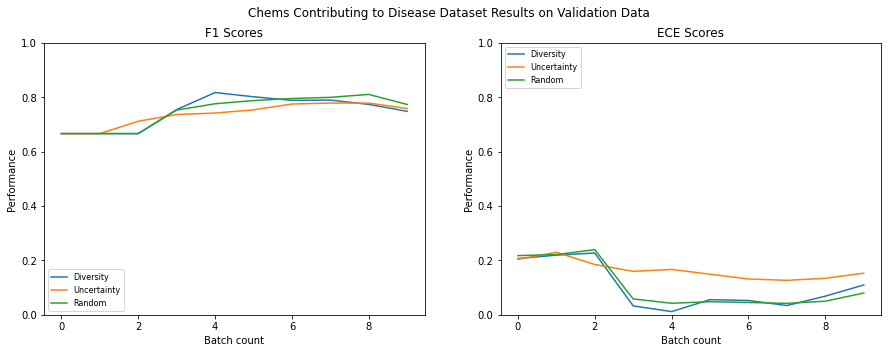

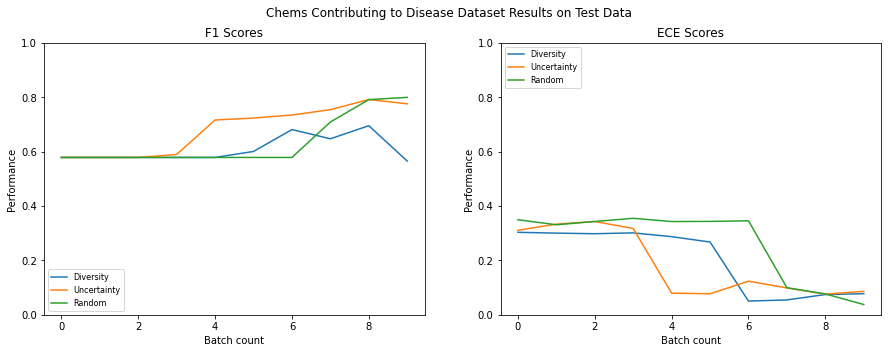

+-----------------------------------------------------------------------------------------------------------------------------------+
|                              Diversity sampling results for the Chems Contributing to Disease Dataset                             |
+-------------------------------+-------+---------------------+----------------------+----------------------+-----------------------+
|            Dataset            | Batch | F1 Score on Val Set | ECE Score on Val Set | F1 Score on Test Set | ECE Score on Test Set |
+-------------------------------+-------+---------------------+----------------------+----------------------+-----------------------+
| Chems Contributing to Disease |   0   |  0.6666666666666666 | 0.20673143543222894  |  0.5789473684210525  |   0.3035314999244832  |
|                               |   1   |  0.6666666666666666 | 0.21951886466754375  |  0.5789473684210525  |  0.30049193530906865  |
|                               |   2   |  0.6666666666666666 

In [ ]:
diversity_res_eval_agg = diversity_res_eval.groupby('alBatch').agg({' f1_val': 'max', ' ece_val': 'min'})
uncertainty_res_eval_agg = uncertainty_res_eval.groupby('alBatch').agg({' f1_val': 'max', ' ece_val': 'min'})
random_res_eval_agg = random_res_eval.groupby('alBatch').agg({' f1_val': 'max', ' ece_val': 'min'})

plot_performance(diversity_res_test['alBatch'], [[diversity_res_eval_agg[" f1_val"].tolist(), diversity_res_eval_agg[" ece_val"].tolist()], [uncertainty_res_eval_agg[" f1_val"].tolist(), uncertainty_res_eval_agg[" ece_val"].tolist()], [random_res_eval_agg[" f1_val"].tolist(), random_res_eval_agg[" ece_val"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'],'Chems Contributing to Disease Dataset Results on Validation Data', 'lower left')
plot_performance(diversity_res_test['alBatch'], [[diversity_res_test[" f1_val"].tolist(), diversity_res_test[" ece_val"].tolist()], [uncertainty_res_test[" f1_val"].tolist(), uncertainty_res_test[" ece_val"].tolist()], [random_res_test[" f1_val"].tolist(), random_res_test[" ece_val"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'Chems Contributing to Disease Dataset Results on Test Data', 'lower left')

column_names = ["Dataset", "Batch", "F1 Score on Val Set", "ECE Score on Val Set", "F1 Score on Test Set", "ECE Score on Test Set"]

printPrettyTable('Diversity sampling results for the Chems Contributing to Disease Dataset', column_names, 
                 'Chems Contributing to Disease', diversity_res_eval_agg, diversity_res_test)

printPrettyTable('Uncertainty sampling results for the Chems Contributing to Disease Dataset', column_names, 
                 'Chems Contributing to Disease', uncertainty_res_eval_agg, uncertainty_res_test)

printPrettyTable('Random sampling results for the eChems Contributing to Disease Dataset', column_names, 
                 'Chems Contributing to Disease', random_res_eval_agg, random_res_test)

# ***Corporate Messaging Dataset***

A data categorization job concerning what corporations actually talk about on social media. Contributors were asked to classify statements as information (objective statements about the company or it's activities), dialog (replies to users, etc.), or action (messages that ask for votes or ask users to click on links, etc.). 

Source: https://www.crowdflower.com/data-for-everyone/



In [ ]:
#read data and results

res_path = 'drive/My Drive/Colab Notebooks/deepALForCalibration/res/'
data_folder = 'drive/My Drive/Colab Notebooks/deepALForCalibration/datasets/mclass/corporate_messaging/'

unlabeled_data_dir = data_folder + '5_train_indexed_corporate_messaging_mclass.csv'

diversity_res_eval_dir = res_path + 'diversity_5-corporate_messaging-lr10-6-1&1&1cw_maxEpoch85.csv'
diversity_res_test_dir = res_path + 'diversity_test_5-corporate_messaging-lr10-6-1&1&1cw_alB10_ep44_it0.csv'
uncertainty_res_eval_dir = res_path + 'uncertainty_5-corporate_messaging-lr10-6-1&1&1cw_maxEpoch85_last.csv'
uncertainty_res_test_dir = res_path + 'uncertainty_test_5-corporate_messaging-lr10-6-1&1&1cw_alB10_ep33_it0.csv'
random_res_eval_dir = res_path + 'random_5-corporate_messaging-lr10-6-1&1&1cw_maxEpoch85.csv'
random_res_test_dir = res_path + 'random_test_5-corporate_messaging-lr10-6-1&1&1cw_alB10_ep36_it0.csv'

data = pd.read_csv(unlabeled_data_dir)
diversity_res_eval = pd.read_csv(diversity_res_eval_dir)
diversity_res_test = pd.read_csv(diversity_res_test_dir)
uncertainty_res_eval = pd.read_csv(uncertainty_res_eval_dir)
uncertainty_res_test = pd.read_csv(uncertainty_res_test_dir)
random_res_eval = pd.read_csv(random_res_eval_dir)
random_res_test = pd.read_csv(random_res_test_dir)

**Performance of DistilBERT model when using active learning for calibration**

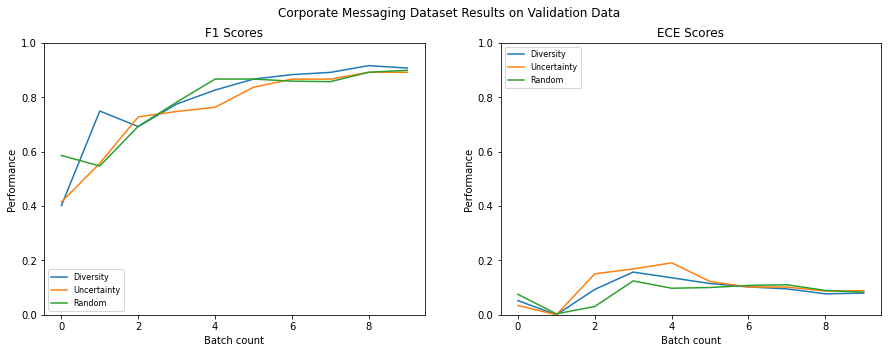

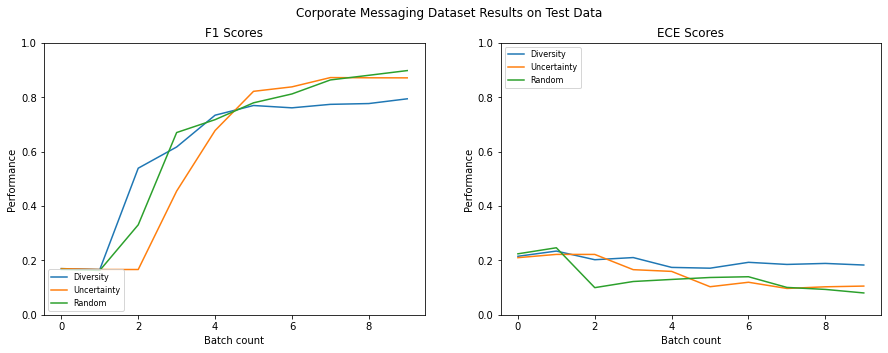

+---------------------------------------------------------------------------------------------------------------------------+
|                               Diversity sampling results for the Corporate Messaging Dataset                              |
+---------------------+-------+---------------------+------------------------+----------------------+-----------------------+
|       Dataset       | Batch | F1 Score on Val Set |  ECE Score on Val Set  | F1 Score on Test Set | ECE Score on Test Set |
+---------------------+-------+---------------------+------------------------+----------------------+-----------------------+
| Corporate Messaging |   0   |  0.4015873015873017 |  0.05227273255586623   | 0.16985138004246286  |   0.2152589146907513  |
|                     |   1   |  0.7496632312266355 | 0.00023959924777350322 | 0.16666666666666666  |  0.23446495563555986  |
|                     |   2   |  0.6925524729324994 |  0.09341183900833132   |  0.5393699874063763  |  0.2026349423278

In [ ]:
diversity_res_eval_agg = diversity_res_eval.groupby('alBatch').agg({' f1_val': 'max', ' ece_val': 'min'})
uncertainty_res_eval_agg = uncertainty_res_eval.groupby('alBatch').agg({' f1_val': 'max', ' ece_val': 'min'})
random_res_eval_agg = random_res_eval.groupby('alBatch').agg({' f1_val': 'max', ' ece_val': 'min'})

plot_performance(diversity_res_test['alBatch'], [[diversity_res_eval_agg[" f1_val"].tolist(), diversity_res_eval_agg[" ece_val"].tolist()], [uncertainty_res_eval_agg[" f1_val"].tolist(), uncertainty_res_eval_agg[" ece_val"].tolist()], [random_res_eval_agg[" f1_val"].tolist(), random_res_eval_agg[" ece_val"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'],'Corporate Messaging Dataset Results on Validation Data', 'lower left')
plot_performance(diversity_res_test['alBatch'], [[diversity_res_test[" f1_val"].tolist(), diversity_res_test[" ece_val"].tolist()], [uncertainty_res_test[" f1_val"].tolist(), uncertainty_res_test[" ece_val"].tolist()], [random_res_test[" f1_val"].tolist(), random_res_test[" ece_val"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'Corporate Messaging Dataset Results on Test Data', 'lower left')

column_names = ["Dataset", "Batch", "F1 Score on Val Set", "ECE Score on Val Set", "F1 Score on Test Set", "ECE Score on Test Set"]

printPrettyTable('Diversity sampling results for the Corporate Messaging Dataset', column_names, 
                 'Corporate Messaging', diversity_res_eval_agg, diversity_res_test)

printPrettyTable('Uncertainty sampling results for the Corporate Messaging Dataset', column_names, 
                 'Corporate Messaging', uncertainty_res_eval_agg, uncertainty_res_test)

printPrettyTable('Random sampling results for the Corporate Messaging Dataset', column_names, 
                 'Corporate Messaging', random_res_eval_agg, random_res_test)

# ***Sentiment Self-driving Cars Dataset***

A simple Twitter sentiment analysis job where contributors read tweets and classified them as very positive, slightly positive, neutral, slightly negative, or very negative. They were also prompted asked to mark if the tweet was not relevant to self-driving cars. 

Source: https://www.crowdflower.com/data-for-everyone/


In [ ]:
#read data and results

res_path = 'drive/My Drive/Colab Notebooks/deepALForCalibration/res/'
data_folder = 'drive/My Drive/Colab Notebooks/deepALForCalibration/datasets/mclass/self_drive/'
unlabeled_data_dir = data_folder + '7_train_indexed_sentiment_twitter_self_drive_mclass.csv'

diversity_res_eval_dir = res_path + 'diversity_7-self_drive-lr10-6-1&1&1cw_maxEpoch55.csv'
diversity_res_test_dir = res_path + 'diversity_test_7-self_drive-lr10-6-1&1&1cw_alB10_ep42_it10.csv'
uncertainty_res_eval_dir = res_path + 'uncertainty_7-self_drive-lr10-6-1&1&1cw_maxEpoch55.csv'
uncertainty_res_test_dir = res_path + 'uncertainty_test_7-self_drive-lr10-6-1&1&1cw_alB10_ep19_it10.csv'
random_res_eval_dir = res_path + 'random_7-self_drive-lr10-6-1&1&1cw_maxEpoch55.csv'
random_res_test_dir = res_path + 'random_test_7-self_drive-lr10-6-1&1&1cw_alB10_ep42_it10.csv'

data = pd.read_csv(unlabeled_data_dir)
diversity_res_eval = pd.read_csv(diversity_res_eval_dir)
diversity_res_test = pd.read_csv(diversity_res_test_dir)
uncertainty_res_eval = pd.read_csv(uncertainty_res_eval_dir)
uncertainty_res_test = pd.read_csv(uncertainty_res_test_dir)
random_res_eval = pd.read_csv(random_res_eval_dir)
random_res_test = pd.read_csv(random_res_test_dir)

**Performance of DistilBERT model when using active learning for calibration**

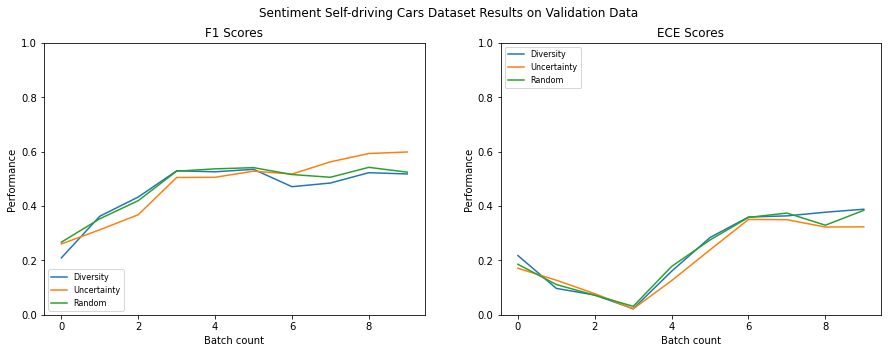

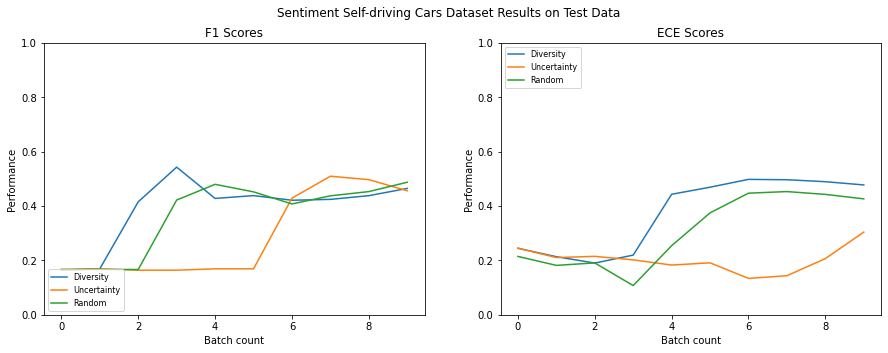

+---------------------------------------------------------------------------------------------------------------------------------+
|                              Diversity sampling results for the Sentiment Self-driving Cars Dataset                             |
+-----------------------------+-------+---------------------+----------------------+----------------------+-----------------------+
|           Dataset           | Batch | F1 Score on Val Set | ECE Score on Val Set | F1 Score on Test Set | ECE Score on Test Set |
+-----------------------------+-------+---------------------+----------------------+----------------------+-----------------------+
| Sentiment Self-driving Cars |   0   | 0.20952380952380956 | 0.21800030628840134  |  0.1641025641025641  |  0.24473701326214545  |
|                             |   1   |  0.3626666666666667 | 0.09712288538614916  |  0.1692047377326565  |  0.21378203598009488  |
|                             |   2   | 0.43327069755641184 | 0.072676225105

In [ ]:
diversity_res_eval_agg = diversity_res_eval.groupby('alBatch').agg({' f1_val': 'max', ' ece_val': 'min'})
uncertainty_res_eval_agg = uncertainty_res_eval.groupby('alBatch').agg({' f1_val': 'max', ' ece_val': 'min'})
random_res_eval_agg = random_res_eval.groupby('alBatch').agg({' f1_val': 'max', ' ece_val': 'min'})

plot_performance(diversity_res_test['alBatch'], [[diversity_res_eval_agg[" f1_val"].tolist(), diversity_res_eval_agg[" ece_val"].tolist()], [uncertainty_res_eval_agg[" f1_val"].tolist(), uncertainty_res_eval_agg[" ece_val"].tolist()], [random_res_eval_agg[" f1_val"].tolist(), random_res_eval_agg[" ece_val"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'],'Sentiment Self-driving Cars Dataset Results on Validation Data', 'lower left')
plot_performance(diversity_res_test['alBatch'], [[diversity_res_test[" f1_val"].tolist(), diversity_res_test[" ece_val"].tolist()], [uncertainty_res_test[" f1_val"].tolist(), uncertainty_res_test[" ece_val"].tolist()], [random_res_test[" f1_val"].tolist(), random_res_test[" ece_val"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'Sentiment Self-driving Cars Dataset Results on Test Data', 'lower left')

column_names = ["Dataset", "Batch", "F1 Score on Val Set", "ECE Score on Val Set", "F1 Score on Test Set", "ECE Score on Test Set"]

printPrettyTable('Diversity sampling results for the Sentiment Self-driving Cars Dataset', column_names, 
                 'Sentiment Self-driving Cars', diversity_res_eval_agg, diversity_res_test)

printPrettyTable('Uncertainty sampling results for the Sentiment Self-driving Cars Dataset', column_names, 
                 'Sentiment Self-driving Cars', uncertainty_res_eval_agg, uncertainty_res_test)

printPrettyTable('Random sampling results for the Sentiment Self-driving Cars Dataset', column_names, 
                 'Sentiment Self-driving Cars', random_res_eval_agg, random_res_test)

# ***Drug Relation Dataset***


Contributors read color-coded sentences and determined what the relationship of a drug was to certain symptoms or diseases. There are two types of relationships. A drug either: * Caused side effects – [Drug] gave me [symptom]

    Was effective against a condition – [Drug] helped my [disease]
    Is prescribed for a certain disease – [Drug] was given to help my [disease]
    Is contraindicated in – [Drug] should not be taken if you have [disease or symptom]
    The second similarity was more about the statement itself. Those broke down into:
    Personal experiences – I started [drug] for [disease]
    Personal experiences negated – [Drug] did not cause [symptom]
    Impersonal experiences – I’ve heard [drug] causes [symptom]
    Impersonal experiences negated – I’ve read [drug] doesn’t cause [symptom]

Source: https://www.crowdflower.com/data-for-everyone/


In [ ]:
#read data and results

res_path = 'drive/My Drive/Colab Notebooks/deepALForCalibration/res/'
data_folder = 'drive/My Drive/Colab Notebooks/deepALForCalibration/datasets/mclass/drug_relation/'
unlabeled_data_dir = data_folder + '8_train_indexed_drug_relation_mclass.csv'

diversity_res_eval_dir = res_path + 'diversity_8-drug_relation-lr10-6-1&1&1cw_maxEpoch80.csv'
diversity_res_test_dir = res_path + 'diversity_test_8-drug_relation-lr10-6-1&1&1cw_alB10_ep25_it0.csv'
uncertainty_res_eval_dir = res_path + 'uncertainty_8-drug_relation-lr10-6-1&1&1cw_maxEpoch80.csv'
uncertainty_res_test_dir = res_path + 'uncertainty_test_8-drug_relation-lr10-6-1&1&1cw_alB10_ep17_it0.csv'
random_res_eval_dir = res_path + 'random_8-drug_relation-lr10-6-1&1&1cw_maxEpoch80.csv'
random_res_test_dir = res_path + 'random_test_8-drug_relation-lr10-6-1&1&1cw_alB10_ep20_it0.csv'

data = pd.read_csv(unlabeled_data_dir)
diversity_res_eval = pd.read_csv(diversity_res_eval_dir)
diversity_res_test = pd.read_csv(diversity_res_test_dir)
uncertainty_res_eval = pd.read_csv(uncertainty_res_eval_dir)
uncertainty_res_test = pd.read_csv(uncertainty_res_test_dir)
random_res_eval = pd.read_csv(random_res_eval_dir)
random_res_test = pd.read_csv(random_res_test_dir)

**Performance of DistilBERT model when using active learning for calibration**

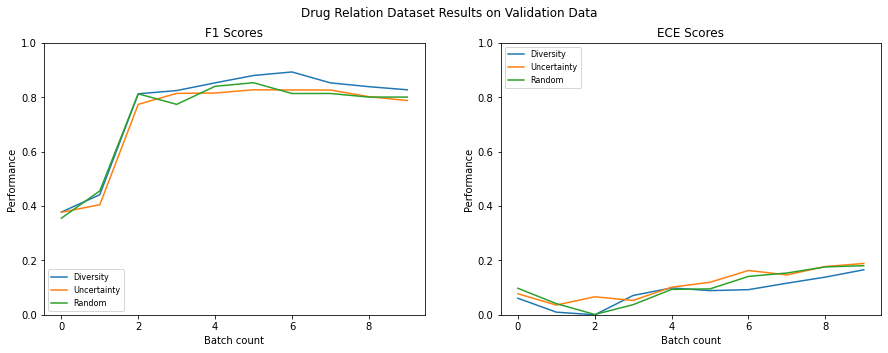

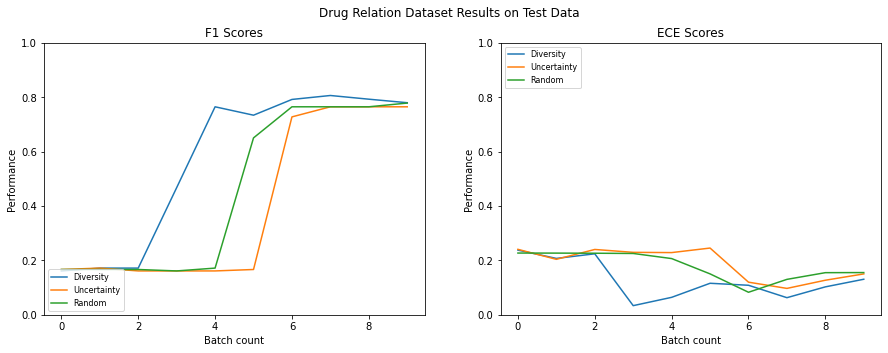

+---------------------------------------------------------------------------------------------------------------------+
|                               Diversity sampling results for the Drug Relation Dataset                              |
+---------------+-------+---------------------+------------------------+----------------------+-----------------------+
|    Dataset    | Batch | F1 Score on Val Set |  ECE Score on Val Set  | F1 Score on Test Set | ECE Score on Test Set |
+---------------+-------+---------------------+------------------------+----------------------+-----------------------+
| Drug Relation |   0   |  0.3780396558174337 |  0.06079273780186978   |  0.1614035087719298  |  0.23800622257921436  |
|               |   1   |  0.4418188327962764 |  0.009695072174072285  | 0.17182130584192434  |  0.20747239473793244  |
|               |   2   |  0.8130763416477702 | 2.8356711069710272e-05 | 0.17182130584192434  |   0.2244250360462401  |
|               |   3   |  0.82498110355

In [ ]:
diversity_res_eval_agg = diversity_res_eval.groupby('alBatch').agg({' f1_val': 'max', ' ece_val': 'min'})
uncertainty_res_eval_agg = uncertainty_res_eval.groupby('alBatch').agg({' f1_val': 'max', ' ece_val': 'min'})
random_res_eval_agg = random_res_eval.groupby('alBatch').agg({' f1_val': 'max', ' ece_val': 'min'})

plot_performance(diversity_res_test['alBatch'], [[diversity_res_eval_agg[" f1_val"].tolist(), diversity_res_eval_agg[" ece_val"].tolist()], [uncertainty_res_eval_agg[" f1_val"].tolist(), uncertainty_res_eval_agg[" ece_val"].tolist()], [random_res_eval_agg[" f1_val"].tolist(), random_res_eval_agg[" ece_val"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'],'Drug Relation Dataset Results on Validation Data', 'lower left')
plot_performance(diversity_res_test['alBatch'], [[diversity_res_test[" f1_val"].tolist(), diversity_res_test[" ece_val"].tolist()], [uncertainty_res_test[" f1_val"].tolist(), uncertainty_res_test[" ece_val"].tolist()], [random_res_test[" f1_val"].tolist(), random_res_test[" ece_val"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'Drug Relation Dataset Results on Test Data', 'lower left')

column_names = ["Dataset", "Batch", "F1 Score on Val Set", "ECE Score on Val Set", "F1 Score on Test Set", "ECE Score on Test Set"]

printPrettyTable('Diversity sampling results for the Drug Relation Dataset', column_names, 
                 'Drug Relation', diversity_res_eval_agg, diversity_res_test)

printPrettyTable('Uncertainty sampling results for the Drug Relation Dataset', column_names, 
                 'Drug Relation', uncertainty_res_eval_agg, uncertainty_res_test)

printPrettyTable('Random sampling results for the Drug Relation Dataset', column_names, 
                 'Drug Relation', random_res_eval_agg, random_res_test)